In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

In [305]:
#Solve the CFL (linear)
# D available locations, E competitive locations C=E\cup E
#utility function v_c^n(beta,distance,x) e.g. v_c^n=-beta*distance-x
#q_n weight of each customer

In [306]:
#Generate data
def generate_instance(D_size, E_size, N_size, width=20, seed=0):
    """
    Generate an instance.
    
    Args:
        D_size (int): Number of available locations
        E_size (int): Number of competitive facilities
        N_size (int): Number of customers
        width (int): width of the square on which customers are uniformly distributed
        seed (int): seed provided to the random number generator

    Returns:
        dict: Diccionario con conjuntos y parámetros generados.
    """
    if seed != 0:
        np.random.seed(seed)

    # Generate random coordinates for facilities and customers
    coord_E = width * np.random.rand(E_size, 2)
    coord_D = width * np.random.rand(D_size, 2)
    coord_N = width * np.random.rand(N_size, 2)

    # Distances 
    theta_d = np.zeros((N_size, D_size))  # L1 distance from customers to available locations
    theta_e = np.zeros((N_size, E_size))  # L1 distance from customers to competitive facilities

    for n in range(N_size):
        for d in range(D_size):
            theta_d[n, d] = np.sum(np.abs(coord_N[n] - coord_D[d]))
        for e in range(E_size):
            theta_e[n, e] = np.sum(np.abs(coord_N[n] - coord_E[e]))

    theta_d = np.round(theta_d, decimals=3)
    theta_e = np.round(theta_e, decimals=3)

    # Weight of customers
    q = np.ones(N_size, dtype=int) #qn=1 

    D = [f"d{i+1}" for i in range(D_size)]
    E = [f"e{i+1}" for i in range(E_size)]
    N = [f"n{i+1}" for i in range(N_size)]

    return {
        "D": D,
        "E": E,
        "N": N,
        "coord_D": coord_D,
        "coord_E": coord_E,
        "coord_N": coord_N,
        "theta_d": theta_d,
        "theta_e": theta_e,
        "q": q
    }


In [307]:
# visualize instance

def visualize_instance(instance, facility_status=None):
    plt.figure(figsize=(6, 6))
    
    # All the locations
    pos_D = {f"Facility_D_{facility}": pos for facility, pos in zip(instance['D'], instance['coord_D'])}
    pos_E = {f"Facility_E_{facility}": pos for facility, pos in zip(instance['E'], instance['coord_E'])}
    pos_N = {f"Customer_{customer}": pos for customer, pos in zip(instance['N'], instance['coord_N'])}
    
    # Available locations 
    for node, coords in pos_D.items():
        facility_id = node.split('_')[-1]  # Get 'd1', 'd2', etc.
        if facility_status and facility_status.get(facility_id) == 1.0:
            color = 'black'  # Color black if the status is 1.0
        else:
            color = 'white'  # Otherwise, color white
        plt.scatter(*coords, color=color, edgecolor='black', s=200, marker='^') 
    
    # Competitive facilities
    for node, coords in pos_E.items():
        plt.scatter(*coords, color='black', s=200, marker='D')
    
    # Customers
    for node, coords in pos_N.items():
        plt.scatter(*coords, color='black', s=100, marker='o')  
        
    #Labels 
    #for node, coords in {**pos_D, **pos_E, **pos_N}.items():
    #    plt.text(coords[0], coords[1], f'{node}\n({coords[0]:.2f}, {coords[1]:.2f})', 
    #            fontsize=10, ha='center', color='black')

    for node, coords in {**pos_D, **pos_E, **pos_N}.items():
        plt.text(coords[0], coords[1], node, fontsize=10, ha='center', color='black')
    
    # Title
    plt.title("Instance visualizations")
    plt.axis('equal')  # Mantener las proporciones iguales
    plt.show()

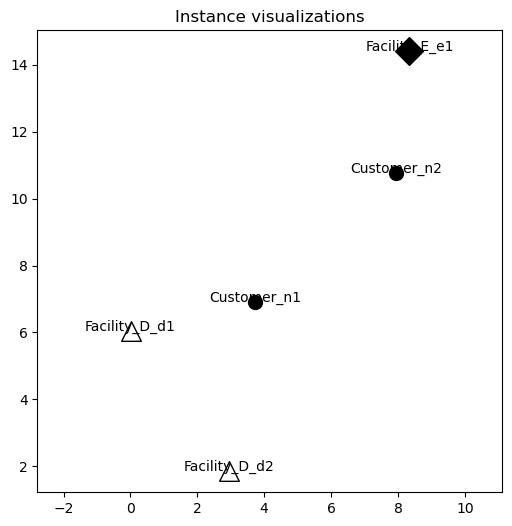

In [309]:
instance = generate_instance(D_size=2, E_size=1, N_size=2, seed=1)
visualize_instance(instance)

In [430]:
def utility_function0(theta, n, c, x, beta_d,beta_a):
    """
    Defines the utility function for a given customer and location.

    Args:
        theta (ndarray): Distance matrix (either theta_d or theta_e).
        c (int): Index of the location.
        n (int): Index of the customer.
        x (list): Parameter indicating additional amenities for customers (for example)
        beta_d (float): Coefficient impacting the distance utility 
        beta_a (float): Coefficient impacting the amenity utility

    Returns:
        float: Computed utility value.
    """
    return -beta_d * theta[n, c] + beta_a*x[n]

#with this function i am not able (in principle) to change the solution


In [455]:
def utility_function(theta, n, c, beta_d,beta_a):
    """
    Defines the utility function for a given customer and location.

    Args:
        theta (ndarray): Distance matrix (either theta_d or theta_e).
        c (int): Index of the location.
        n (int): Index of the customer.
        x (list): Parameter indicating additional amenities for customers (for example)
        beta_d (float): Coefficient impacting the distance utility
        beta_a (float): Coefficient (variable) indicating if there are amenities or not 

    Returns:
        float: Computed utility value.
    """
    return -(beta_d-beta_a[n]) * theta[n, c]

#here beta_d is a fixed parameter, but beta_a is a `feature'

In [456]:
#Define the linear optimization model for the CFL problem 

def CFL_MILP(instance, r, beta_a, beta_d=0.1):
    """
    Solves the optimization problem using Gurobi.

    Args:
        instance (dict): Instance generated
        x_values (list): Binary parameter values for x (change to something generally)
        beta (float): Coefficient beta for the utility function.
        r (integer) : budget (number of facilities to locate)
    """
    D = instance["D"]
    E = instance["E"]
    N = instance["N"]
    theta_d = instance["theta_d"]
    theta_e = instance["theta_e"]
    q = {N[i]: instance["q"][i] for i in range(len(N))}

    # Create the model
    model = gp.Model("CFL_MILP")

    # Variables
    z = model.addVars(D, vtype=gp.GRB.BINARY, name="z")  # Binary variables for the location of the facilities
    w = model.addVars(N, D, vtype=gp.GRB.CONTINUOUS, lb=0, name="w")  # Continuous auxiliary variables

    # Compute a_{nd} and b_n using the utility function
    a = {(N[n], D[d]): np.exp(utility_function(theta_d, n, d, beta_d,beta_a)) for n in range(len(N)) for d in range(len(D))}
    b = {N[n]: sum(np.exp(utility_function(theta_e, n, e, beta_d,beta_a)) for e in range(len(E))) for n in range(len(N))}

    # Objective function
    obj = gp.quicksum(q[n] * (gp.quicksum(a[n, d] / b[n] * z[d] for d in D) -
                          gp.quicksum(a[n, d] / b[n] * w[n, d] for d in D)) for n in N)
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints
    model.addConstr(gp.quicksum(z[d] for d in D) == r, "Budget")

    model.addConstrs(
        w[n, d] >= gp.quicksum(a[n, d] / b[n] * z[k] for k in D) -
                    gp.quicksum(a[n, d] / b[n] * w[n, k] for k in D) - (1 - z[d])
        for n in N for d in D
    )

    # Solve the model
    model.optimize()

    # Display results
    if model.status == gp.GRB.OPTIMAL:
        print("\nOptimal Solution:")
        print("z:", {d: z[d].x for d in D})
        z_sol={d: z[d].x for d in D}
        return z_sol
        #print("w:", {(n, d): w[n, d].x for n in N for d in D if w[n, d].x > 1e-6})
    else:
        print("No optimal solution found.")

In [458]:
# Parameters and solve
r=1
beta_a=[0,0] #no amenities
beta_d=0.5
z_sol=CFL_MILP(instance, r, beta_a,beta_d)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 6 columns and 18 nonzeros
Model fingerprint: 0xdb151e2f
Variable types: 4 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [7e-03, 4e+01]
  Objective range  [7e-03, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 5 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 20.2193 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.021933474810e+01, best bound 2.021933474810e+01, gap 0.0000%

Optimal Solution:
z: {'d1': 1.0, 'd2': 0.0}


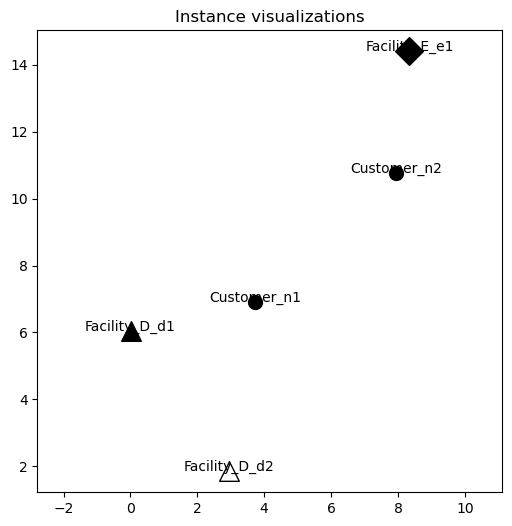

In [459]:
visualize_instance(instance, z_sol)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5 rows, 6 columns and 18 nonzeros
Model fingerprint: 0x7830fca1
Variable types: 4 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [7e-03, 1e+00]
  Objective range  [7e-03, 5e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 5 rows and 6 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 0.049018 
No other solutions better than 0.049018

Optimal solution found (tolerance 1.00e-04)
Best objective 4.901801385738e-02, best bound 4.901801385738e-02, gap 0.0000%

Optimal Solution:
z: {'d1': 0.0, 'd2': 1.0}


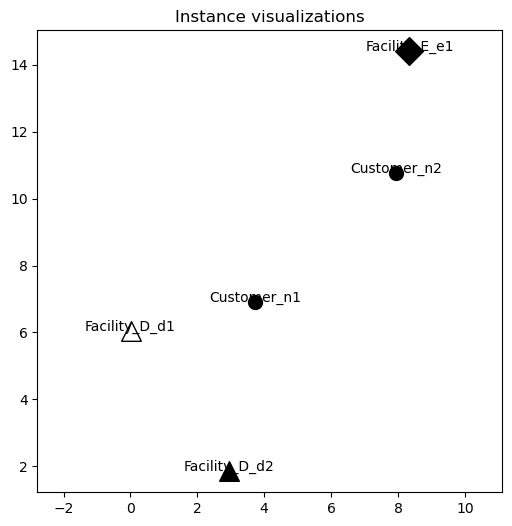

In [461]:
beta_a=[1,0] #customer 1 has amenity
z_sol=CFL_MILP(instance, r, beta_a,beta_d)
visualize_instance(instance, z_sol)

In [415]:
utility_function(theta_e, 0, 0, [1,0], 0.1,14)

12.797